Copyright Rigetti Computing 2021.

## Sampling and Readout Errors using pyQuil

Import relevant modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import itertools

import numpy as np

from pyquil import get_qc, Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
from pyquil.paulis import *

from tqdm import tqdm

import networkx as nx

### Sampling Error

Previously, we used the `WavefunctionSimulator`. This time, we will primarily use a `QuantumComputer`.

In [2]:
wfn_sim = WavefunctionSimulator()

n_qubits = 2
qc = get_qc(f'{n_qubits}q-qvm')
qubits = qc.qubits()
print(qubits)

[0, 1]


Let us first compute what the expectation value of the observable $Z$ is in a fair (quantum) dice: the Hadamard state.

In [3]:
prog = Program(H(0))
Z_expectation = wfn_sim.expectation(prog, sZ(0)+0.0)
print(Z_expectation)

0j


Now let us try to estimate it via sampling. First, we simply obtain some shots.

In [4]:
n_shots = 1000

prog = Program()
ro = prog.declare('ro', 'BIT', 1)
prog += H(0)
prog += MEASURE(0, ro[0])
prog.wrap_in_numshots_loop(n_shots)

exe = qc.compile(prog)

samples = qc.run(exe)
print(samples.shape)
print(samples[:5])

(1000, 1)
[[1]
 [1]
 [0]
 [1]
 [0]]


Next, we estimate the expectation value $\langle Z \rangle$. Remember that $\langle 0 \vert Z \vert 0 \rangle=1$ and $\langle 1 \vert Z \vert 1 \rangle=-1$.

In [5]:
Z_eigs = 1 - 2*samples
Z_expect = np.mean(Z_eigs)
print(Z_expect)

-0.01


Ok, so it's close, though not exactly equal, to our ideal value. Let us perform several of the above experiments, and obtain a distribution of such averages. (Recall: The Central Limit Theorem says this should look like a bell-shaped curve).

100%|██████████| 1000/1000 [00:16<00:00, 59.35it/s]


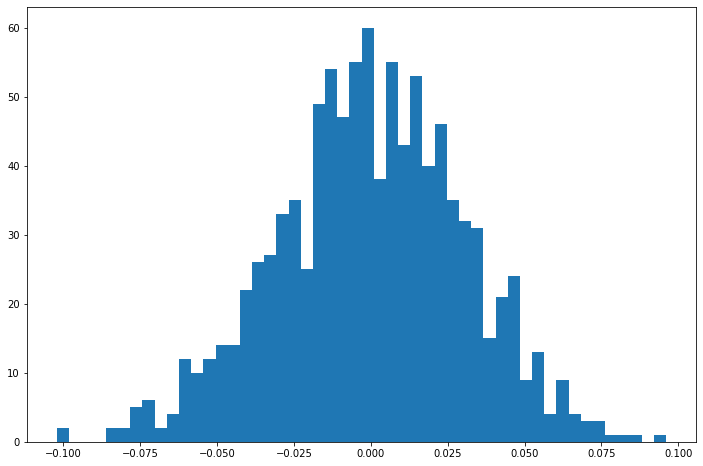

In [6]:
n_expts = 1000

Z_expects = []

for _ in tqdm(range(n_expts)):
    
    samples = qc.run(exe)
    Z_eigs = 1 - 2*samples
    Z_expect = np.mean(Z_eigs)
    Z_expects.append(Z_expect)
    
plt.figure(figsize=(12, 8))
plt.hist(Z_expects, bins=50)
plt.show()

We can also estimate expectation values of other observables, such as $X$ or $Y$. But in order to do so, we need to rotate into the appropriate basis, since our quantum computer can really only measure in the $Z$ (computational) basis.<br>

In order to measure $X$, note that $HZH = X$, so that $\langle \psi \vert X \vert \psi \rangle = \langle \psi \vert HZH \vert \psi \rangle$, so that we can simply apply an $H$ gate before measuring, then carrying out the usual procedure.

First, let's compute what the ideal value is.

In [7]:
prog = Program(H(0))
X_expectation = wfn_sim.expectation(prog, sX(0)+0.0)
print(X_expectation)

(0.9999999999999998+0j)


Next, let's estimate via sampling.

In [8]:
n_shots = 1000

prog = Program()
ro = prog.declare('ro', 'BIT', 1)
prog += H(0)

# apply (another) H to perform a measurement in the X basis
prog += H(0)

# now measure as usual
prog += MEASURE(0, ro[0])
prog.wrap_in_numshots_loop(n_shots)

exe = qc.compile(prog)

And now let's estimate $X$ via sampling.

100%|██████████| 1000/1000 [00:06<00:00, 144.00it/s]


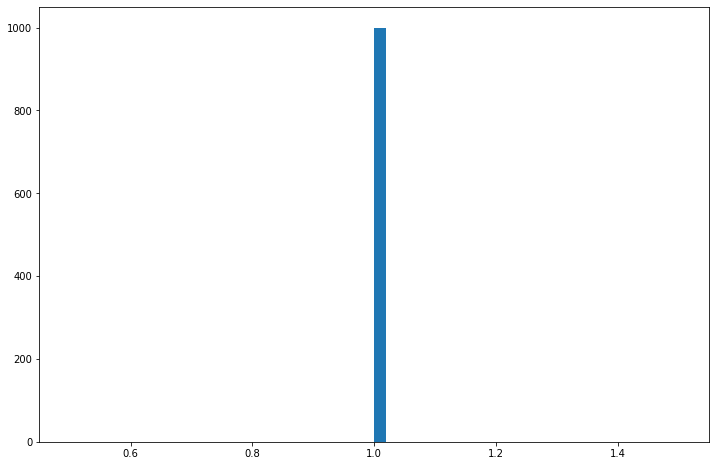

In [9]:
n_expts = 1000

X_expects = []

for _ in tqdm(range(n_expts)):
    
    samples = qc.run(exe)
    X_eigs = 1 - 2*samples
    X_expect = np.mean(X_eigs)
    X_expects.append(X_expect)
    
plt.figure(figsize=(12, 8))
plt.hist(X_expects, bins=50)
plt.show()

Similarly, note that $U^{\dagger}ZU=-Y$ where $U = RX(-\pi/2)$, so we can just apply $RX(-\pi/2)$ before measuring, and then carrying out the usual procedure (but taking care to take care of the minus sign).

In [10]:
# ideal value
prog = Program(H(0))
Y_expectation = wfn_sim.expectation(prog, sY(0)+0.0)
print(Y_expectation)

0j


In [11]:
# via sampling
n_shots = 1000

prog = Program()
ro = prog.declare('ro', 'BIT', 1)
prog += H(0)

# rotate into Y-basis
prog += RX(-np.pi/2, 0)

# now measure as usual
prog += MEASURE(0, ro[0])
prog.wrap_in_numshots_loop(n_shots)

exe = qc.compile(prog)

print(exe.program)

DECLARE ro BIT[1]
RX(pi/2) 0
RZ(pi/2) 0
MEASURE 0 ro[0]
HALT



100%|██████████| 1000/1000 [00:17<00:00, 57.63it/s]


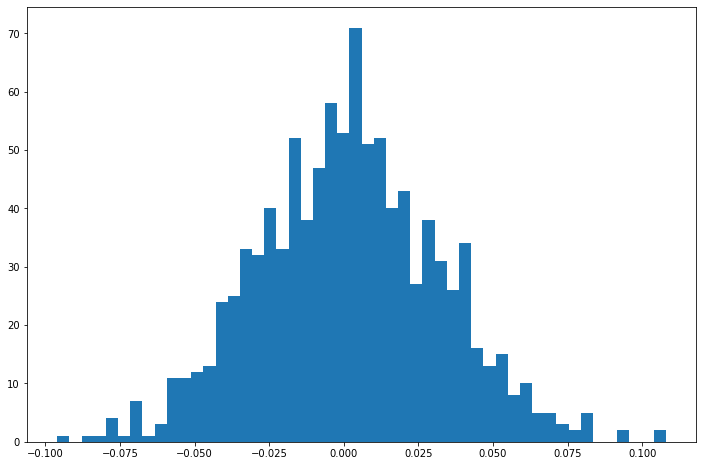

In [12]:
n_expts = 1000

Y_expects = []

for _ in tqdm(range(n_expts)):
    
    samples = qc.run(exe)
    Y_eigs = -1.0 * (1 - 2*samples)
    Y_expect = np.mean(Y_eigs)
    Y_expects.append(Y_expect)
    
plt.figure(figsize=(12, 8))
plt.hist(Y_expects, bins=50)
plt.show()

### Readout Error

There is a simple way to introduce readout error in pyQuil. The syntax is given [here](https://pyquil-docs.rigetti.com/en/stable/apidocs/autogen/pyquil.quil.Program.define_noisy_readout.html).

In [13]:
n_shots = 1000

p00 = 0.85
p11 = 0.92

prog = Program()
ro = prog.declare('ro', 'BIT', 1)
prog.define_noisy_readout(0, p00, p11)
prog += H(0)
prog += MEASURE(0, ro[0])
prog.wrap_in_numshots_loop(n_shots)

exe = qc.compile(prog)

100%|██████████| 1000/1000 [00:16<00:00, 59.24it/s]


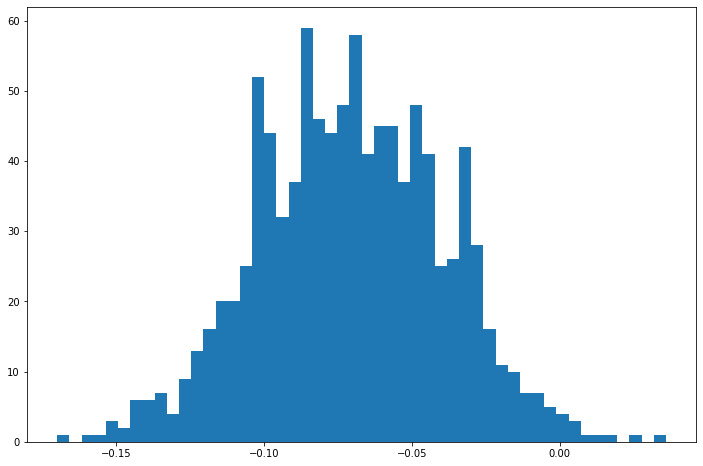

In [14]:
n_expts = 1000

Z_expects = []

for _ in tqdm(range(n_expts)):
    
    samples = qc.run(exe)
    Z_eigs = 1 - 2*samples
    Z_expect = np.mean(Z_eigs)
    Z_expects.append(Z_expect)
    
plt.figure(figsize=(12, 8))
plt.hist(Z_expects, bins=50)
plt.show()

Notice how readout error has caused the center of the Bull curve to shift!

### Confusion matrix inversion

Let's now repeat the above analysis to measure the observable $ZZ$ in the Bell state.

In [15]:
n_shots = 1000

# readout noise on qubit 0
p00_q0 = 0.87
p11_q0 = 0.91

# readout noise on qubit 1
p00_q1 = 0.93
p11_q1 = 0.86

noisy_prog = Program()
noisy_prog.define_noisy_readout(0, p00_q0, p11_q0)
noisy_prog.define_noisy_readout(1, p00_q1, p11_q1)

prog = Program()
ro = prog.declare('ro', 'BIT', 2)
prog += noisy_prog
prog += H(0)
prog += CNOT(0,1)
for idx, q in enumerate([0,1]):
    prog += MEASURE(q, ro[idx])
prog.wrap_in_numshots_loop(n_shots)

exe = qc.compile(prog)

Ideally, since $ZZ \left( \frac{\vert 00 \rangle + \vert 11 \rangle}{\sqrt{2}}\right) = 1$, in the absence of errors the expectation value would be 1. However, readout errors can shift the measured expectation value away from the ideal value, as we observe below.

100%|██████████| 1000/1000 [00:33<00:00, 30.28it/s]


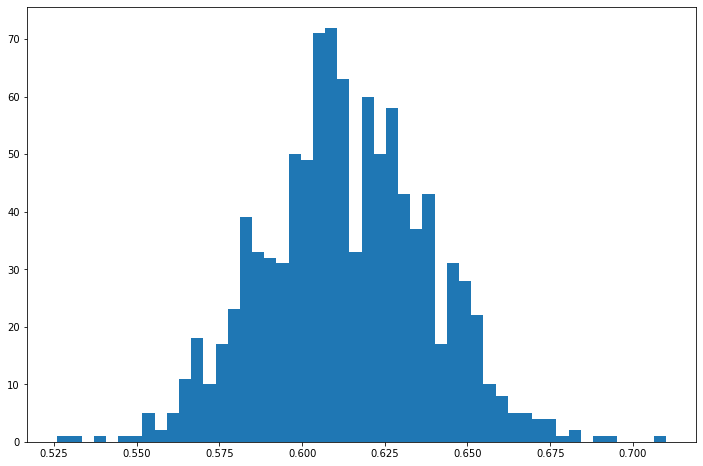

In [16]:
qc = get_qc(f'{n_qubits}q-qvm')
n_expts = 1000

ZZ_expects = []

for _ in tqdm(range(n_expts)):
    
    samples = qc.run(exe)
    ZZ_eigs = np.prod(1 - 2*samples, axis=1)
    ZZ_expect = np.mean(ZZ_eigs)
    ZZ_expects.append(ZZ_expect)
    
plt.figure(figsize=(12, 8))
plt.hist(ZZ_expects, bins=50)
plt.show()

Let us now try to correct for this readout error. As explained in the slides, we can make use of Bayes identity $p(read=x) = \sum_{y} p(read=x \vert sampled=y) \cdot p(sampled=y)$ to infer the true sampling probabilities $p(sampled=y)$.

First, we estimate what the empirical probabilities are, i.e. $p(read=x)$.

In [17]:
qc = get_qc(f'{n_qubits}q-qvm')
samples = qc.run(exe)
samples_str = [''.join(str(q) for q in shot) for shot in samples]

all_bitstrings = list(''.join(bb) for bb in itertools.product(['0','1'], repeat=2))

probs_empirical = []
for bitstring in all_bitstrings:
    frac = samples_str.count(bitstring) / n_shots
    probs_empirical.append(frac)

Next, we estimate the confusion matrix $p(read=x \vert sampled=y)$. We do this by successively preparing all possible bitstrings $y$, then read them out and measure the fraction of times we obtain each possible bitstring.

In [18]:
qc = get_qc(f'{n_qubits}q-qvm')
n_expts = 1000

dim = 2**n_qubits
confusion_matrix = np.zeros((dim, dim))

# for (bb1,bb2) in itertools.product(all_bitstrings, repeat=2):
for idx, bb in enumerate(all_bitstrings):
    
    prog = Program()
    prog += noisy_prog
    
    for q, x in enumerate(bb):
        if x=='0':
            pass
        elif x=='1':
            prog += X(q)
            
    for i, q in enumerate([0,1]):
        prog += MEASURE(q, ro[i])

    prog.wrap_in_numshots_loop(n_shots)
    
    exe = qc.compile(prog)
    samples = qc.run(exe)
    samples_str = [''.join(str(q) for q in shot) for shot in samples]
    measured_fracs = [samples_str.count(bitstring)/n_shots for bitstring in all_bitstrings]
    confusion_matrix[:,idx] = measured_fracs

/Users/sohaib/Documents/pyquil/pyquil/quil.py:1180: UserWarning: Please DECLARE all memory. I'm adding a declaration for the `ro` register, but I won't do this for you in the future.
  "Please DECLARE all memory. I'm adding a declaration for the `ro` register, "


In vector notation, we can express $p(read=x) = \sum_{y} p(read=x \vert sampled=y) \cdot p(sampled=y)$ as $\vec{p} = P \vec{q}$, where $\vec{p}$ are the empirical probabilities, $P$ is the confusion matrix, and $q$ are the true sampling probabilities. To infer $\vec{q}$, we can simply invert this equation and solve $\vec{q} = P^{-1} \vec{p}$.

In [19]:
conf_mat_inv = np.linalg.inv(confusion_matrix)
probs_correct = conf_mat_inv @ probs_empirical

With the corrected probabilities ($\vec{q}$) we can infer the expectation value of the observable $ZZ$.

In [20]:
ZZ_empirical = (probs_empirical[0] + probs_empirical[3]) - (probs_empirical[1] + probs_empirical[2])
ZZ_corrected = (probs_correct[0] + probs_correct[3]) - (probs_correct[1] + probs_correct[2])

print(f"Empirical ZZ estimate: {ZZ_empirical}")
print(f"Corrected ZZ estimate: {ZZ_corrected}")

Empirical ZZ estimate: 0.562
Corrected ZZ estimate: 0.8965972964990718


We see that the corrected estimate is much closer to the ideal value of 1.0.

Note however that the corrected "probabilities" are really only quasi-probabilities, as even though they sum to 1

In [21]:
print(np.sum(probs_correct))

1.0


they need not necessarily all be non-negative

In [22]:
print(probs_correct)

[0.48376423 0.02600961 0.02569175 0.46453442]
